In [2]:
import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
import pandas as pd
import importlib
import pickle
from mpl_toolkits.mplot3d import Axes3D
from pysr import PySRRegressor
import os 
import webbrowser
import ODE_solver

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:

lam = 1.3e-1
v = 2.098e-17
xi = 1e34
#Mp = 1.22e19 # GeV
Mp = 1
y0, v0 = 5, 0
tc = xi/(Mp*np.sqrt(lam))

In [4]:

importlib.reload(ODE_solver)



<module 'ODE_solver' from 'c:\\Users\\diego\\OneDrive\\Documentos\\Universidad\\Cosmologia\\Efolds\\ODE_solver.py'>

In [5]:
t_span = (0, 2000)
t = np.linspace(t_span[0], t_span[1], t_span[1]*10)
y0_array = np.linspace(1.1,5, 100)   # Array de condiciones iniciales para y,v
v0_array = np.linspace(0,0.5, 100)


In [6]:
#Resolvemos para cada combinación de condiciones iniciales
results = ODE_solver.solve_ODEs_parallel(t_span, t, y0_array, v0_array, batch_size=50) #Results es un diccionario que contiene las soluciones numéricas (t, y, vel, acc, potencial, damping, forcing)

Processed 350/10000

KeyboardInterrupt: 

In [2]:
potencial_array = results['potencial']
y_array = results['y']
vel_array = results['vel']


NameError: name 'results' is not defined

In [ ]:
#potencial_array = np.load('../data/ode_results/potencial.npy')
#y_array = np.load('../data/ode_results/field.npy')
#vel_array = np.load('../data/ode_results/field_derivative.npy')

In [3]:
#epsilon_array = ODE_solver.calculate_epsilon(t, vel_array, potencial_array)

In [4]:
#mean_epsilon = np.mean(epsilon_array, axis=1)
#std_epsilon = np.std(epsilon_array, axis=1)
#idx1 = np.argmin(mean_epsilon >= 1)
#idx2 = np.argmax(mean_epsilon[idx1:] >= 1)
#
#plt.figure(figsize=(10, 6))
#plt.plot(t, mean_epsilon, label=r'Mean con $v_0=\{0,1\}$', color='darkblue', linewidth=2)
#plt.fill_between(t, mean_epsilon - std_epsilon, mean_epsilon + std_epsilon, alpha=0.2, color='blue', label='±1 STD')
#plt.axvline(t[idx1], color='red', linestyle='--', label=r'$\epsilon = 1$')
#plt.axvline(t[idx2], color='green', linestyle='--', label=r'$\epsilon = 1$')
#
#
#
#plt.yscale('log')
#plt.xlabel(r'$\tilde{t}$', fontsize=12)
#plt.ylabel(r'$\epsilon(\tilde{t})$', fontsize=12)
#plt.xlim(0, 380)
#plt.legend()
#plt.grid(True, which="both", linestyle='--', alpha=0.5)
#plt.show()

In [5]:
t0_array = np.full(y_array.shape[1], np.nan)  # Initialize with number of trajectories

for i in range(y_array.shape[1]):  # Loop over trajectories (columns)
    condition = (potencial_array[:, i] > 0.5 * vel_array[:, i]**2)
    if np.any(condition):
        t0_array[i] = t[condition][0]  # First time where condition is met

NameError: name 'np' is not defined

In [6]:
t_end_array = np.full(y_array.shape[1], np.nan)

for i in range(y_array.shape[1]):
    condition = (y_array[:, i] < 1)  
    if np.any(condition):
        t_end_array[i] = t[condition][0]  

NameError: name 'np' is not defined

In [7]:
# reordenamos los arrays en forma de matriz
t0_mesh = t0_array.reshape(len(y0_array), len(v0_array))
t_end_mesh = t_end_array.reshape(len(y0_array), len(v0_array))



NameError: name 't0_array' is not defined

In [8]:
y0_mesh, v0_mesh = np.meshgrid(y0_array, v0_array, indexing='ij')  

dtype = [('y0', float), ('v0', float), ('t0', float), ('t_end', float)]
result_mesh = np.empty_like(y0_mesh, dtype=dtype)
result_mesh['y0'] = y0_mesh
result_mesh['v0'] = v0_mesh
result_mesh['t0'] = t0_mesh
result_mesh['t_end'] = t_end_mesh

NameError: name 'np' is not defined

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(122)
plt.contourf(y0_mesh, v0_mesh, t_end_mesh, levels=20, cmap='plasma')
plt.colorbar(label='End time (t_end)')
plt.xlabel('y0'); plt.ylabel('v0')
plt.title('First time when y < 1')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

: 

In [15]:
H_array = np.sqrt(lam)*Mp*np.sqrt((1/xi**2)*vel_array**2 + (((1/xi)*np.exp(2*y_array) - v**2)**2/(1 + np.exp(2*y_array))**2)/(12)) # Unidades de 1/t= m


In [16]:
N = np.zeros(H_array.shape[1])  

for i in range(H_array.shape[1]):
    mask = (t >= t0_array[i]) & (t <= t_end_array[i])
    t_masked = t[mask]
    H_masked = H_array[mask, i]
    
    if len(t_masked) > 0:
        N[i] = tc*np.trapezoid(H_masked, t_masked)
    else:
        N[i] = np.nan  

N_mesh_full = N.reshape(len(y0_array), len(v0_array))  # Shape: (n_y0, n_v0)

In [17]:
# Velocity field

Vel = np.zeros(vel_array.shape[1])

for i in range(vel_array.shape[1]):
    mask = (t >= t0_array[i]) & (t <= t_end_array[i])
    t_masked = t[mask]
    vel_masked = vel_array[mask, i]
    
    if len(t_masked) > 0:
        Vel[i] = np.trapezoid(vel_masked, t_masked)
    else:
        Vel[i] = np.nan
        
Vel_mesh_full = Vel.reshape(len(y0_array), len(v0_array))

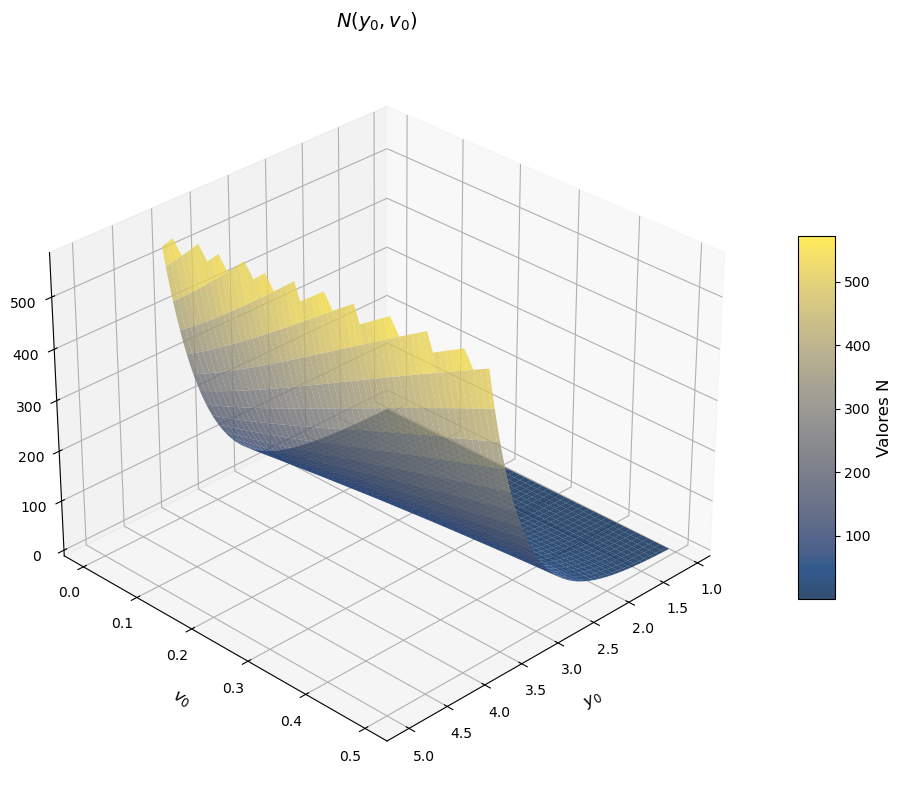

In [18]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(
    y0_mesh, 
    v0_mesh, 
    N_mesh_full,
    cmap='cividis',      
    edgecolor='none',    
    alpha=0.8,          
    rstride=2,         
    cstride=2
)


ax.set_xlabel('$y_0$', fontsize=12, labelpad=10)
ax.set_ylabel('$v_0$', fontsize=12, labelpad=10)
ax.set_zlabel('$N(y_0, v_0)$', fontsize=12, labelpad=10)
ax.set_title('$N(y_0, v_0)$', fontsize=14, pad=20)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Valores N', fontsize=12)

# ángulo 
ax.view_init(elev=30, azim=45)  # Elevation and azimuth angles

plt.tight_layout()
plt.show()

In [19]:
import plotly.graph_objects as go
import numpy as np

# Convert to Plotly
fig = go.Figure(data=[go.Surface(
    x=y0_mesh,
    y=v0_mesh, 
    z=N_mesh_full,
    colorscale='Viridis',
    opacity=0.8,
    contours = {
        "x": {"show": True, "start": y0_mesh.min(), "end": y0_mesh.max(), "size": 0.5, "color":"white"},
        "y": {"show": True, "start": v0_mesh.min(), "end": v0_mesh.max(), "size": 0.5, "color":"white"}
    }
)])

fig.update_layout(
    title='N(y₀, v₀)',
    scene=dict(
        xaxis_title='y₀',
        yaxis_title='v₀',
        zaxis_title='N(y₀, v₀)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=800,
    height=600
)

fig.show()

In [20]:
data = pd.DataFrame({
    'y0': y0_mesh.ravel(),
    'v0': v0_mesh.ravel(),
    'N': N_mesh_full.ravel()})

In [21]:
os.environ["JULIA_NUM_THREADS"] = "16"

model = PySRRegressor(
    procs=16,
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["log", "exp", "inv", "square"],
    complexity_of_constants=1,
    constraints={"x1":0},
    nested_constraints={
        "log": {"exp": 1, "inv": 1, "square": 1},
        "exp": {"log": 1, "inv": 1, "square": 1},
        "inv": {"log": 1, "exp": 1, "square": 1},
        "square": {"log": 0, "exp": 0, "inv": 1}
    },
    progress=True,
    elementwise_loss="loss(x, y) = (sum((x - y)^2))/length(x)",
    verbosity=1
)



X0 = data[['y0', 'v0']].values
N = data['N'].values

#model.fit(X0,N)

In [22]:
def N_of_chi(x0, x1): 
    return (3/4)*np.exp(2*x0) + x1/12

In [23]:
def N_of_chi(x0, x1): #pysr complexity 8
    return np.exp(x1 + 2*(x0 - 0.7372046))

In [24]:
def N_of_chi(x0, x1): # pysr complexity 10
    return np.exp(2*x0 -1.5078472)*x1**2

In [25]:
def symbolic_model(x0, x1): # pysr complexity 13
    return np.exp( 1.1656301*x1  + 2*x0 -1.505182) - 1/x0

In [26]:
def N_of_chi(x0, x1): 
    return (1/6)*x1**(-1) + 3*x0/np.sqrt(2) - 5.13789

In [27]:
def N_of_chi(x0, x1):
    return np.exp(2*x0 + x1)

In [28]:
N_symbolic = N_of_chi(y0_mesh, v0_mesh)

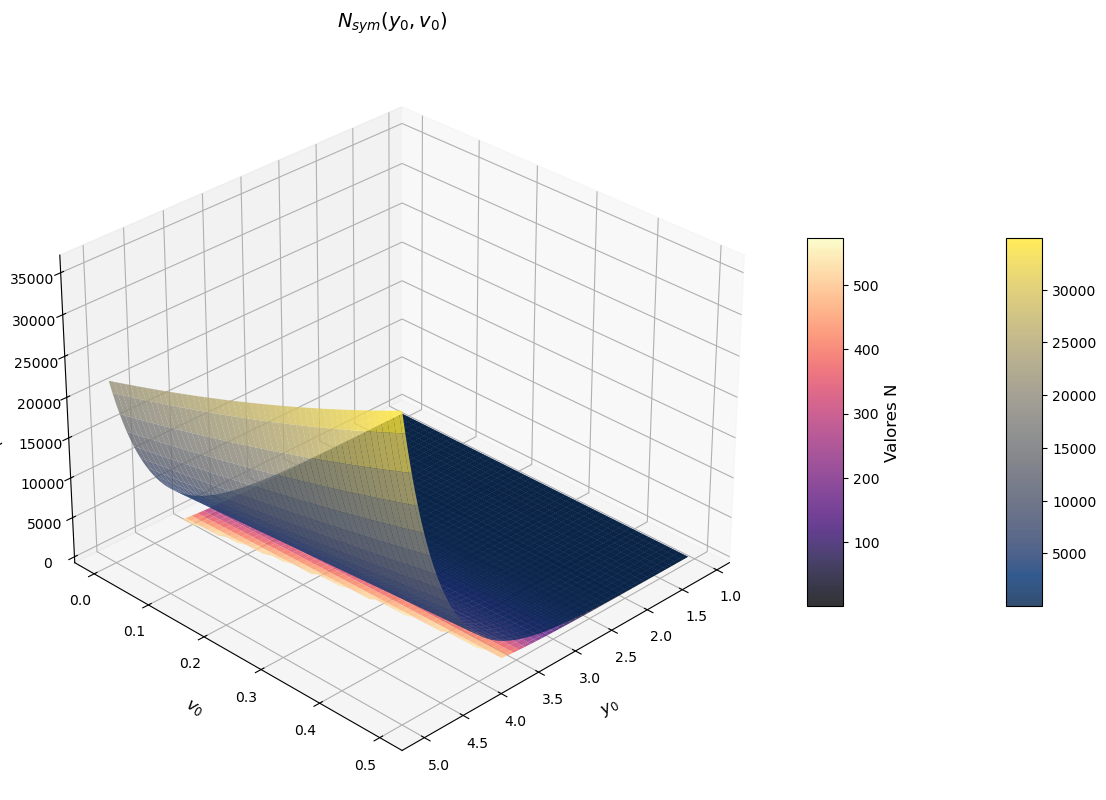

In [29]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(
    y0_mesh, 
    v0_mesh, 
    N_symbolic,
    edgecolor='none',    
    cmap='cividis',
    alpha=0.8,          
    rstride=2,         
    cstride=2
)
surf_num = ax.plot_surface(
    y0_mesh, 
    v0_mesh, 
    N_mesh_full,
    edgecolor='none',    
    cmap='magma',
    alpha=0.8,          
    rstride=2,         
    cstride=2
)



ax.set_xlabel('$y_0$', fontsize=12, labelpad=10)
ax.set_ylabel('$v_0$', fontsize=12, labelpad=10)
ax.set_zlabel('$N(y_0, v_0)$ ', fontsize=12, labelpad=10)
ax.set_title('$N_{sym}(y_0, v_0)$', fontsize=14, pad=20)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar = fig.colorbar(surf_num, ax=ax, shrink=0.5, aspect=10 )
cbar.set_label('Valores N', fontsize=12)

# ángulo 
ax.view_init(elev=30, azim=45)  # Elevation and azimuth angles

plt.tight_layout()
plt.show()

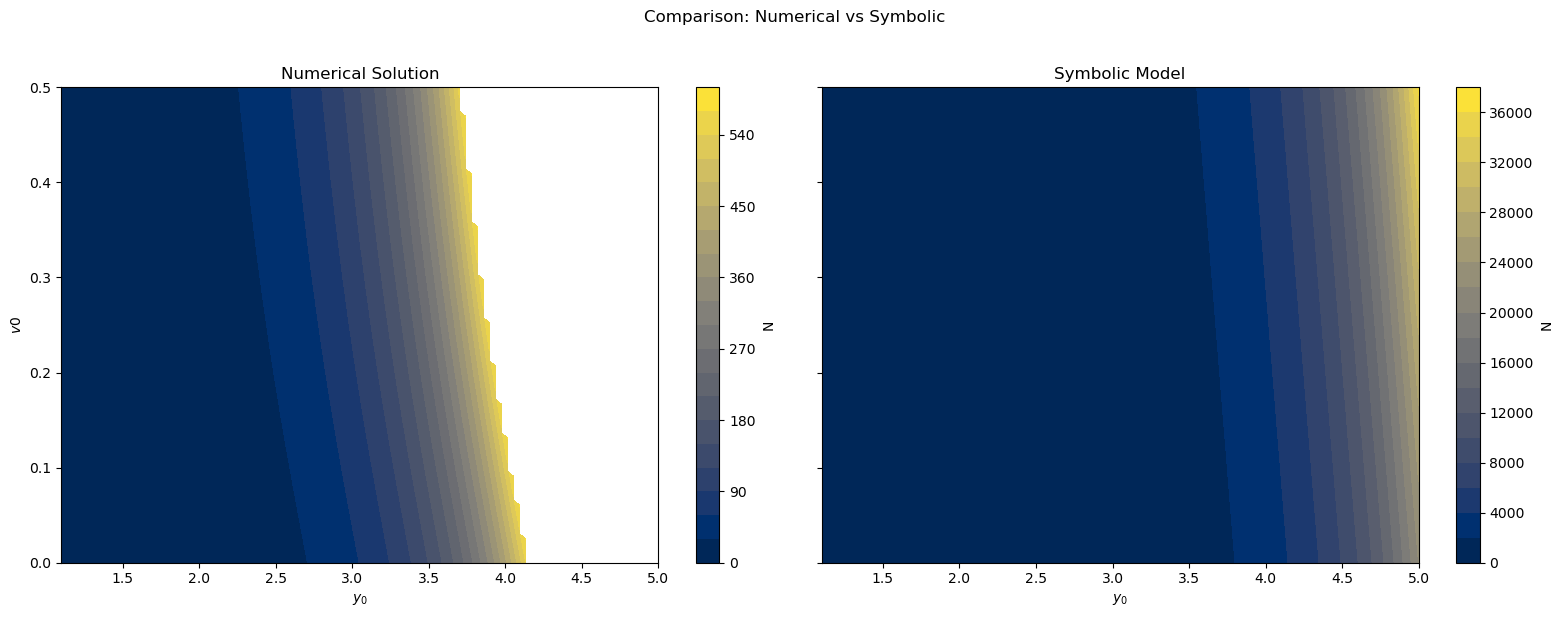

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Numerical
cont1 = ax1.contourf(y0_mesh, v0_mesh, N_mesh_full, levels=20, cmap='cividis')
ax1.set_title('Numerical Solution')
ax1.set_xlabel('$y_0$'); ax1.set_ylabel('$v0$')
fig.colorbar(cont1, ax=ax1, label='N')

# Symbolic
cont2 = ax2.contourf(y0_mesh, v0_mesh, N_symbolic, levels=20, cmap='cividis')
ax2.set_title('Symbolic Model')
ax2.set_xlabel('$y_0$')
fig.colorbar(cont2, ax=ax2, label='N')

plt.suptitle('Comparison: Numerical vs Symbolic', y=1.02)
plt.tight_layout()

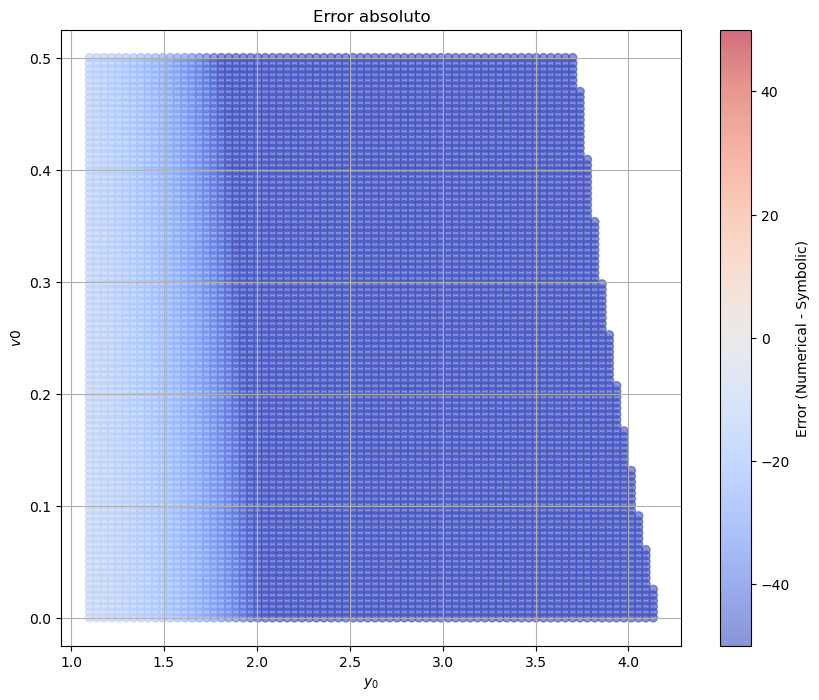

In [31]:
plt.figure(figsize=(10, 8))
sc = plt.scatter(y0_mesh.ravel(), v0_mesh.ravel(), 
                c=(N_mesh_full - N_symbolic).ravel(),
                cmap='coolwarm', vmin=-50, vmax=50, alpha=0.6)
plt.colorbar(sc, label='Error (Numerical - Symbolic)')
plt.xlabel('$y_0$'); plt.ylabel('$v0$')
plt.title('Error absoluto')
plt.grid(True)

In [32]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Surface(x=y0_mesh, y=v0_mesh, z=N_mesh_full,
                        name='Numerical', colorscale='Viridis'))
fig.add_trace(go.Surface(x=y0_mesh, y=v0_mesh, z=N_symbolic,
                        name='Symbolic', colorscale='Plasma', opacity=0.7))

fig.update_layout(
    title='Interactive Numerical vs Symbolic',
    scene=dict(
        xaxis_title='y0',
        yaxis_title='v0',
        zaxis_title='N'
    ),
    width=800, height=600
)
fig.write_html("comparison.html")
webbrowser.open("comparison.html")

True

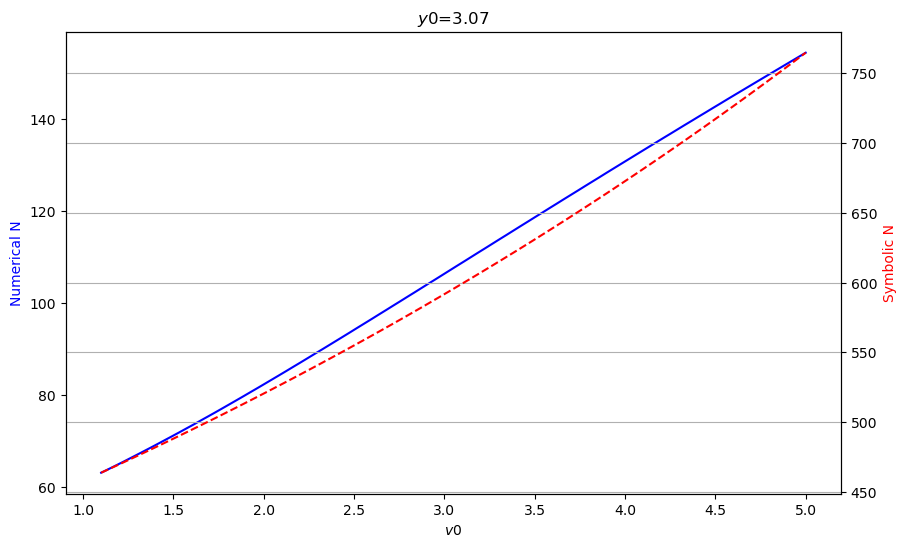

In [33]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(y0_array, N_mesh_full[50, :], 'b-', label='Numerical')
ax1.set_xlabel('$v0$'); ax1.set_ylabel('Numerical N', color='b')

ax2 = ax1.twinx()
ax2.plot(y0_array, N_symbolic[50, :], 'r--', label='Symbolic')
ax2.set_ylabel('Symbolic N', color='r')

plt.title(f'$y0$={y0_array[50]:.2f}')
plt.grid(True)



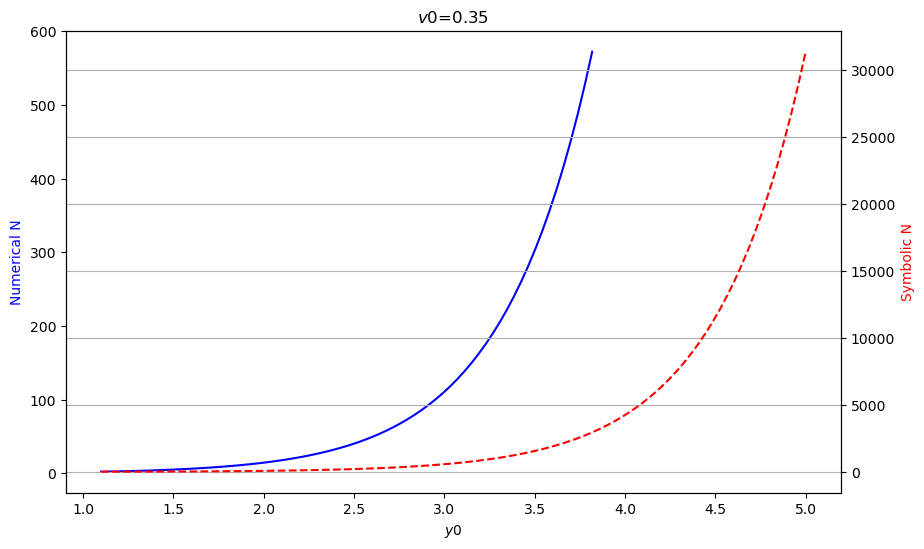

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(y0_array, N_mesh_full[:, 70], 'b-', label='Numerical')
ax1.set_xlabel('$y0$'); ax1.set_ylabel('Numerical N', color='b')

ax2 = ax1.twinx()
ax2.plot(y0_array, N_symbolic[:, 70], 'r--', label='Symbolic')
ax2.set_ylabel('Symbolic N', color='r')

plt.title(f'$v0$={v0_array[70]:.2f}')
plt.grid(True)